**Step 0 - install and import dependencies**

In [1]:
#!pip install pythainlp
#!pip install tensorflow_text
#!pip install umap-learn

In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections

from gensim.test.utils import common_texts

from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [3]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [4]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


In [5]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*'?+]/g"

specialchar_pattern = re.compile(special_characters)

In [6]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [7]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [8]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [9]:
#create regex compiler for removal of .
dot_pattern = re.compile(r"\.+")

In [10]:
#create regex compiler for removal of \
backslash_pattern = re.compile(r"\\+")

In [11]:
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน' , 'กก' , 'บ้าน' , '[\'' , 'นะคะ' , 'ค่ะ' , 'ครับ' , 'นะครับ' , 'นะ' , 'ไหม' , 'ดิชั้น' , 'รีวิว' ,
                 'review' , 'สั่ง' , 'เกริ่น' , 'วัง' , 'สวัสดี' , 'เด' , 'ที่ตั้ง' , 'ผม' , 'ดิฉัน' , 'ฉัน' , 'ดิชั้น' , 'ตั้งอยู่' , 'น']
screening_words = stopwords + removed_words

new_words = {"สตารบัก" , 'พนักงาน' , 'บรรยากาศ' , 'เอ๊กซ์เพรสโซ่ไอซ์' , 'ลาเต้ไอซ' , 'คาราเมล' , 'มัคคิอาโต้' , 'ชาอัสสัม', 'ชาซีลอน',
             'อิตาเลียนโซดา' , 'ทะเล' , 'Macchiato' , 'อุดหนุน' , 'เบอเกอรี่' , 'ทรูคอฟฟี่' ,'สาขา.*' , 'อเมซอน' ,'ชานม' , 'ชานมไข่มุก',
             'ชาไต้หวัน' , 'ชานมไต้หวัน' , 'คาเฟอีน' , 'สไตล์' , 'จองล่วงหน้า' , 'นั่งชิล' , 'กรอบ' , '.*เค้ก' , 'มอคค่า' , 'ไม่อร่อย' 'ไม่ผ่าน',
             'ค่อนข้าง' , 'ไม่ค่อย' , 'ห้ามพลาด' , 'รถไฟฟ้า' , 'ปลาร้า' , 'เป็ด.*'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [12]:
#clean and tokenize sentences. count the occurences of each word
df['Review'] = df['Review'].apply(lambda x: emoji_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: specialchar_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: number_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: space_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: dot_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: backslash_pattern.sub(r'', x))
df['Review_tokenized'] = df['Review'].apply(lambda x: tokenize_to_list(x))

In [13]:
df

,Review ID,Review,Review_tokenized
0,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดินเ...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เดิน..."
1,2,ArtofCoffeeKasetsartเป็นร้านกาแฟรสชาติเยี่ยมรา...,"[ArtofCoffeeKasetsart, ร้านกาแฟ, รสชาติ, เยี่ย..."
2,3,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คา...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป..."
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อร่อย, ทาน,..."
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...,"[ชอบ, ทาน, กิน, อาหาร, เวียดนาม, ซอย, ราชครู, ..."
...,...,...,...
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำหมูเฮาเลยพากันลงมากินส...,"[ค่ำ, เพื่อน, ส้มตำ, หมู, เฮา, ลงมา, กิน, ส้มต..."
296,297,ร้านสะอาดดีตกแต่งสวยงามมีที่จอดรถราคาเมนูต่างๆ...,"[สะอาด, ดี, ตกแต่ง, สวยงาม, ที่จอดรถ, ราคา, เม..."
297,298,เช้าๆรีบๆวิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้องหา...,"[เช้า, รีบ, วิ่ง, เข่า, ห้องเรียน, แทบ, ต้องหา..."
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆข้างๆร้านๆHappyMangoคร...,"[ร้านกาแฟ, HappyMango, อาทิตย์, นัด, เพื่อน, น..."


In [14]:
df_train = pd.read_csv("Train_file.csv")

In [15]:
df_train['review'] = df_train['review'].apply(str)

In [16]:
df_train

,reviewID,review
0,1,ร้านนี้จะอยู่เส้นสันกำแพง-แม่ออน เลยแยกบ่...
1,2,สั่งไป2 เมนู คือมัชฉะลาเต้ร้อน กับ ไอศครีมชาเข...
2,3,ครัววงเดือน \n\nหิวดึกๆ ตระเวนหาร้านทาน มาเจอ...
3,4,จะว่าเป็นเจ้าประจำก็คงไม่ผิด แต่ก็ไม่กล้า...
4,5,ถ้าคิดถึงสลัดผมคิดถึงร้านนี้เป็นร้านแรกๆเลยครั...
...,...,...
6198,6199,ร้านโรตีสายไหมพญาวัง อยู่ถนนรัตนโกสินทร์ หลังโ...
6199,6200,ข้าวผัดคอหมูย่าง ข้าวผัดมากลิ่นหอม คอหมูย่างอร...
6200,6201,ร้านอาหารมีหลายโซน แนะนำให้เดินดูก่อนค่อยเลือก...
6201,6202,ขนมปังร้านในเครือยามาซากิ จริงๆร้านนี้เปิ...


In [17]:
#clean and tokenize sentences. count the occurences of each word
df_train['review'] = df_train['review'].apply(lambda x: emoji_pattern.sub(r'', x))
df_train['review'] = df_train['review'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_train['review'] = df_train['review'].apply(lambda x: number_pattern.sub(r'', x))
df_train['review'] = df_train['review'].apply(lambda x: space_pattern.sub(r'', x))
df_train['review'] = df_train['review'].apply(lambda x: dot_pattern.sub(r'', x))
df_train['review'] = df_train['review'].apply(lambda x: backslash_pattern.sub(r'', x))
df_train['review_tokenized'] = df_train['review'].apply(lambda x: tokenize_to_list(x))

In [18]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_train.review_tokenized.values)]

In [52]:
import gensim

In [74]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=40)

In [76]:
model.build_vocab(documents)

In [79]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [80]:
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

2021-12-18 03:55:28,870 : WARNING : Effective 'alpha' higher than previous training cycles
2021-12-18 03:55:28,871 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 10851 vocabulary and 30 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2021-12-18T03:55:28.871443', 'gensim': '4.1.2', 'python': '3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'train'}
2021-12-18 03:55:29,227 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-18 03:55:29,234 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-18 03:55:29,237 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-18 03:55:29,238 : INFO : EPOCH - 1 : training on 444871 raw words (391224 effective words) took 0.4s, 1073323 effective words/s
2021-12-18 03:55:29,583 : INFO : worker thread finished; awaiting finish of 2 more threads
2021

2021-12-18 03:55:36,062 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-18 03:55:36,069 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-18 03:55:36,072 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-18 03:55:36,072 : INFO : EPOCH - 20 : training on 444871 raw words (391198 effective words) took 0.4s, 1113038 effective words/s
2021-12-18 03:55:36,428 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-18 03:55:36,436 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-18 03:55:36,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-18 03:55:36,441 : INFO : EPOCH - 21 : training on 444871 raw words (391122 effective words) took 0.4s, 1066758 effective words/s
2021-12-18 03:55:36,788 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-18 03:55:36,798 : INFO : worker thread finished; awaiting finish of 1 more thread

2021-12-18 03:55:43,256 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-18 03:55:43,265 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-18 03:55:43,268 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-18 03:55:43,269 : INFO : EPOCH - 40 : training on 444871 raw words (390964 effective words) took 0.4s, 1105511 effective words/s
2021-12-18 03:55:43,269 : INFO : Doc2Vec lifecycle event {'msg': 'training on 17794840 raw words (15646060 effective words) took 14.4s, 1086690 effective words/s', 'datetime': '2021-12-18T03:55:43.269944', 'gensim': '4.1.2', 'python': '3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'train'}


In [81]:
vector_review = []
for token in df.Review_tokenized.values:
    vetor = model.infer_vector(token)
    vector_review.append(vetor)

In [82]:
vector_review[0:10]

[array([ 0.26217213,  0.40353435, -0.3825864 , -0.4695278 , -0.30607733,
        -0.80584556,  0.6023379 ,  0.23535451, -0.692311  ,  0.15369917,
         0.34245485, -1.7525132 ,  0.60655004,  0.22133343, -0.5464463 ,
        -0.4664208 ,  0.11013512, -1.3310943 , -1.1833962 ,  0.48417097,
        -0.6112145 , -0.9122838 ,  0.5022611 ,  0.19676429,  0.032568  ,
         0.411926  , -0.2510721 ,  0.31893662, -0.9497701 , -1.4580301 ],
       dtype=float32),
 array([-0.8994684 ,  0.04109651,  0.47660112, -0.69920427, -1.307472  ,
         0.41712016,  0.5346676 , -0.5583933 , -0.6971416 ,  0.01136723,
         0.03857318, -0.3065502 , -0.44962746, -0.08866298, -0.04050852,
        -0.6041082 ,  0.6319461 , -0.06355345, -0.5505625 ,  0.7432564 ,
        -0.22151202, -0.03603111, -0.6100213 ,  0.30377322, -0.29723877,
         0.05828317,  1.2082491 , -0.27128255, -0.73438686, -0.536445  ],
       dtype=float32),
 array([ 2.7322984 , -0.31862876,  0.51882803,  0.03610979, -0.43283513,
   

**Step 2 - document clustering using KMeans**

C:\Users\Cromagnon-PC\anaconda3\envs\tf2.4gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Text(0, 0.5, 'WCSS')

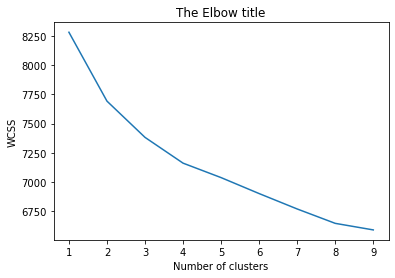

In [83]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(vector_review)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [84]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(vector_review)

df['KMeans ID'] = kmeans.labels_

In [85]:
df['KMeans ID'].value_counts()

3    111
2     89
0     61
1     39
Name: KMeans ID, dtype: int64

In [86]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [87]:
#clean and tokenize sentences. count the occurences of each word
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [88]:
df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,สวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาวWongnai...,"[เพื่อน, สมาชิก, ร้านอาหาร, WongnaiStarbucks, ...","[(ร้านกาแฟ, 12), (กาแฟ, 10), (ร้านอาหาร, 6), (..."
1,1,ร้านส้มตำเจ๊พิมอยู่ถนนเลี่ยงตลาดหนองมนเป็นร้าน...,"[ส้มตำ, เจ๊, พิม, ถนน, เลี่ยง, ตลาด, หนอง, มน,...","[(ส้มตำ, 5), (บอ, 4), (ร้านอาหาร, 4), (กิน, 4)..."
2,2,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คา...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ทาน, 13), (อร่อย, 10), (กาแฟ, 10), (อาหาร, 8..."
3,3,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดินเ...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เดิน...","[(ร้านกาแฟ, 13), (กิน, 11), (ทาน, 10), (ชานมไข..."


In [89]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(vector_review)

fig = px.scatter(components, x=0, y=1, color=df['KMeans ID'].astype("category"))
fig.show()

In [90]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 12), ('กาแฟ', 10), ('ร้านอาหาร', 6), ('ทาน', 5), ('น่ารัก', 4), ('นั่ง', 4), ('บรรยากาศ', 4), ('ร', 4), (':', 3), ('ม', 3)]

Cluster ID : 1

Most common words include : [('ส้มตำ', 5), ('บอ', 4), ('ร้านอาหาร', 4), ('กิน', 4), ('อร่อย', 4), ('ยำ', 3), ('แซ่บ', 3), ('ครั้งแรก', 3), ('ดีล', 3), ('เพื่อน', 3)]

Cluster ID : 2

Most common words include : [('ทาน', 13), ('อร่อย', 10), ('กาแฟ', 10), ('อาหาร', 8), ('ร้านอาหาร', 7), ('กิน', 6), ('รสชาติ', 5), ('ลอง', 4), ('ร้านกาแฟ', 4), ('ชอบ', 4)]

Cluster ID : 3

Most common words include : [('ร้านกาแฟ', 13), ('กิน', 11), ('ทาน', 10), ('ชานมไข่มุก', 9), ('ชอบ', 8), ('กาแฟ', 8), ('สาขา', 7), ('เจอ', 6), ('หา', 6), ('เดิน', 5)]



**result discussion**

* Cluster 1: เกี่ยวกับร้านอาหาร ร้านกาแฟ ที่บรรยากาศดีน่านั่ง
* Cluster 2: เกี่ยวกับร้านอาหารรสแซ่บ เช่น ส้มตำ ยำ
* Cluster 3: เกี่ยวกับการลองทานร้านอาหาร กาแฟ แล้วชอบในรสชาติ
* Cluster 4: เกี่ยวกับการเสาะแสวงหาร้านกาแฟ ชานมไข่มุกแฟรนไชส์ที่กินแล้วชอบ

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [91]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(vector_review, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=4, affinity="cosine")
model.fit(vector_review)
df['Agglomerative ID'] = model.labels_

In [92]:
df['Agglomerative ID'].value_counts()

0    296
1      2
2      1
3      1
Name: Agglomerative ID, dtype: int64

In [93]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [94]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [95]:
fig = px.scatter(components, x=0, y=1, color=df['Agglomerative ID'].astype("category"))
fig.show()

In [96]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 501), ('รสชาติ', 412), ('ทาน', 405), ('ดี', 346), ('กาแฟ', 316), ('กิน', 314), ('เมนู', 304), ('อาหาร', 279), ('ราคา', 262), ('(', 257)]

Cluster ID : 1

Most common words include : [('ปลา', 16), ('กิน', 15), ('เค้า', 15), ('ญี่ปุ่น', 9), ('(', 9), ('อร่อย', 7), ('ทาน', 7), (')', 7), ('ชิ้น', 7), ('ดีล', 7)]

Cluster ID : 2

Most common words include : [('กิน', 12), ('"', 10), ('จาน', 10), ('-', 9), ('บาท', 7), ('สายพาน', 6), ('ชิ้น', 6), ('เนื้อ', 5), ('อาหาร', 5), ('ราคา', 5)]

Cluster ID : 3

Most common words include : [('เป็ด', 10), ('บาท', 5), ('ทอด', 4), ('โต๊ะ', 3), ('ทาน', 3), ('ห่าน', 2), ('พะโล้', 2), ('ห้อง', 2), ('เนื้อ', 2), ('จาน', 2)]



**result discussion**

โมเดล Hierarchical Clustering จัดกลุ่มออกมาได้ผลลัพธ์ที่ imbalance